# Preprocessing Forex data

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('EURUSD_data')

# Select features and target
features = data[['Open', 'High', 'Low', 'Close', 'Adj Close']]
target = data['Close']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Use the 'Close' price as target
    return np.array(X), np.array(y)

seq_length = 60  # Using 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Building LSTM model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# LSTM layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           42400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 72651 (283.79 KB)
Trainable params: 72651 (283.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the model

In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/120
64/64 [==============================] - 4s 39ms/step - loss: 0.0162 - val_loss: 7.5230e-04
Epoch 2/120
64/64 [==============================] - 2s 32ms/step - loss: 0.0029 - val_loss: 7.0293e-04
Epoch 3/120
64/64 [==============================] - 2s 33ms/step - loss: 0.0025 - val_loss: 6.5610e-04
Epoch 4/120
64/64 [==============================] - 2s 32ms/step - loss: 0.0024 - val_loss: 6.5476e-04
Epoch 5/120
64/64 [==============================] - 2s 33ms/step - loss: 0.0022 - val_loss: 6.2813e-04
Epoch 6/120
64/64 [==============================] - 2s 32ms/step - loss: 0.0022 - val_loss: 6.3407e-04
Epoch 7/120
64/64 [==============================] - 2s 32ms/step - loss: 0.0020 - val_loss: 7.8802e-04
Epoch 8/120
64/64 [==============================] - 2s 33ms/step - loss: 0.0021 - val_loss: 6.0639e-04
Epoch 9/120
64/64 [==============================] - 2s 34ms/step - loss: 0.0022 - val_loss: 6.0115e-04
Epoch 10/120
64/64 [==============================] - 2s 33ms/st

# Saving the model using Pickle

In [19]:
import pickle

# Assume 'model' is your trained LSTM model
model_filename = 'LSTM_model.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as {model_filename}")

Model saved as LSTM_model.pkl


In [1]:
# Loading the model
import pickle
with open('LSTM_model.pkl', 'rb') as file:
    model = pickle.load(file)

print("Model loaded successfully")

Model loaded successfully


# Model Evaluation

### 1. Numerical

In [16]:
# Predicting on test data
predicted_prices = model.predict(X_test)

# Inverse transform the predicted and actual values to get them in the original scale
predicted_prices = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], predicted_prices], axis=1))[:, -1]
actual_prices = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate the model
mse = np.mean((predicted_prices - actual_prices) ** 2)
print(f"Mean Squared Error: {mse}")

16/16 [==============================] - 1s 10ms/step
Mean Squared Error: 2.118742062866888e-05


In [17]:
from sklearn.metrics import r2_score
# Calculate R-squared
r_squared = r2_score(actual_prices, predicted_prices)
print(f"R-squared: {r_squared}")

R-squared: 0.9859677022488446


In [20]:
import numpy as np
import statsmodels.api as sm

# Adding a constant to the predicted prices to represent the intercept
X = sm.add_constant(predicted_prices)

# Fit the model (y = actual_prices)
model = sm.OLS(actual_prices, X).fit()

# Get the p-values
p_values = model.pvalues
print(f"P-value of the model: {p_values[1]}")

# Alternatively, print the summary of the model to see all details
print(model.summary())

P-value of the model: 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.758e+04
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:28:50   Log-Likelihood:                 2030.1
No. Observations:                 509   AIC:                            -4056.
Df Residuals:                     507   BIC:                            -4048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0142     

### 3. Graphical

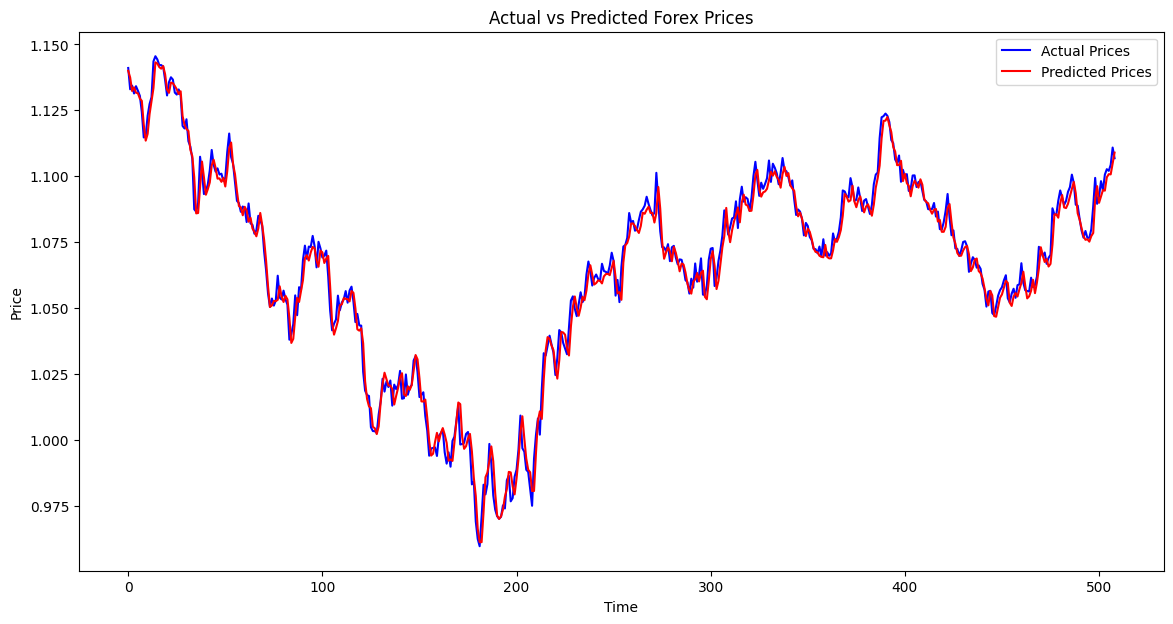

In [19]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Forex Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()